# Deeper CNN

## GoogLeNet / Inception V1

In [8]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
#https://github.com/jrosebr1/imutils
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import skimage

In [1]:
from keras import layers
from keras.models import Model

from functools import partial

#224x224 image

conv1x1 = partial(layers.Conv2D, kernel_size=1, activation='relu')
conv3x3 = partial(layers.Conv2D, kernel_size=3, padding='same', activation='relu')
conv5x5 = partial(layers.Conv2D, kernel_size=5, padding='same', activation='relu')

def inception_module(in_tensor, c1, c3_1, c3, c5_1, c5, pp):
    conv1 = conv1x1(c1)(in_tensor)

    conv3_1 = conv1x1(c3_1)(in_tensor)
    conv3 = conv3x3(c3)(conv3_1)

    conv5_1 = conv1x1(c5_1)(in_tensor)
    conv5 = conv5x5(c5)(conv5_1)

    pool_conv = conv1x1(pp)(in_tensor)
    pool = layers.MaxPool2D(3, strides=1, padding='same')(pool_conv)

    merged = layers.Concatenate(axis=-1)([conv1, conv3, conv5, pool])
    return merged

def aux_clf(in_tensor, n_classes=1000):
    avg_pool = layers.AvgPool2D(5, 3)(in_tensor)
    conv = conv1x1(128)(avg_pool)
    flattened = layers.Flatten()(conv)
    dense = layers.Dense(1024, activation='relu')(flattened)
    dropout = layers.Dropout(0.7)(dense)
    out = layers.Dense(n_classes, activation='softmax')(dropout)
    return out

def inception_net(in_shape=(224,224,3), n_classes=1000, opt='sgd'):
    in_layer = layers.Input(in_shape)

    conv1 = layers.Conv2D(64, 7, strides=2, activation='relu', padding='same')(in_layer)
    pad1 = layers.ZeroPadding2D()(conv1)
    pool1 = layers.MaxPool2D(3, 2)(pad1)
    conv2_1 = conv1x1(64)(pool1)
    conv2_2 = conv3x3(192)(conv2_1)
    pad2 = layers.ZeroPadding2D()(conv2_2)
    pool2 = layers.MaxPool2D(3, 2)(pad2)

    inception3a = inception_module(pool2, 64, 96, 128, 16, 32, 32)
    inception3b = inception_module(inception3a, 128, 128, 192, 32, 96, 64)
    pad3 = layers.ZeroPadding2D()(inception3b)
    pool3 = layers.MaxPool2D(3, 2)(pad3)

    inception4a = inception_module(pool3, 192, 96, 208, 16, 48, 64)
    inception4b = inception_module(inception4a, 160, 112, 224, 24, 64, 64)
    inception4c = inception_module(inception4b, 128, 128, 256, 24, 64, 64)
    inception4d = inception_module(inception4c, 112, 144, 288, 32, 48, 64)
    inception4e = inception_module(inception4d, 256, 160, 320, 32, 128, 128)
    pad4 = layers.ZeroPadding2D()(inception4e)
    pool4 = layers.MaxPool2D(3, 2)(pad4)

    aux_clf1 = aux_clf(inception4a, n_classes)
    aux_clf2 = aux_clf(inception4d, n_classes)

    inception5a = inception_module(pool4, 256, 160, 320, 32, 128, 128)
    inception5b = inception_module(inception5a, 384, 192, 384, 48, 128, 128)
    pad5 = layers.ZeroPadding2D()(inception5b)
    pool5 = layers.MaxPool2D(3, 2)(pad5)

    avg_pool = layers.GlobalAvgPool2D()(pool5)
    dropout = layers.Dropout(0.4)(avg_pool)
    preds = layers.Dense(n_classes, activation='softmax')(dropout)

    model = Model(in_layer, [preds, aux_clf1, aux_clf2])
    model.compile(loss="categorical_crossentropy", optimizer=opt,
                  metrics=["accuracy"])
    return model


Using TensorFlow backend.


In [2]:
model = inception_net()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 114, 114, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)   0           zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2d_2 (

In [67]:
def pre_process(width, height, path):
    """
    Resize and rescale images stored in image folder.
    
    Return pre-processed data and labels for the classes based
    on sub-directories in the image folder
    """
    #containers for pre-processed image data and class labels
    data = []
    labels = []

    #images directory contains 3 sub-directories: 'poison_ivy', 'poison_oak', 'poison_sumac'
    #randomly get image paths and shuffle them
    # current path 'C:\\Users\\jltsa\\Desktop\\Project_2\\images'
    image_paths = sorted(list(paths.list_images(path)))
    random.seed(42)
    random.shuffle(image_paths)

    #preprocess images to width x height pixels as required for LeNet
    for image_path in image_paths:
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is not None:
            #crop center of image
            shorter_edge = min(image.shape[:2])
            crop_height = (image.shape[0] - shorter_edge) / 2
            crop_width = (image.shape[1] - shorter_edge) / 2
            cropped_img = image[int(crop_height):int(crop_height + shorter_edge),
                              int(crop_width):int(crop_width + shorter_edge)]
            image = skimage.transform.resize(cropped_img, (width,height))
            image = img_to_array(image)
            data.append(image)
    
            #Extract class labels
            label = image_path.split(os.path.sep)[-2]
            if label == 'poison_ivy':
                label = 0
            elif label == 'poison_oak':
                label = 1
            else:
                label = 2
            labels.append(label)
       
    #Scal pixel intensities from 0 to 1
    data = np.array(data, dtype='float')
    labels = np.array(labels)
    
    return data, labels

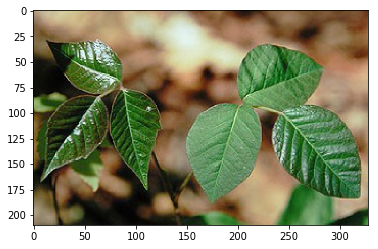

In [44]:
plt.imshow(img)
plt.show()

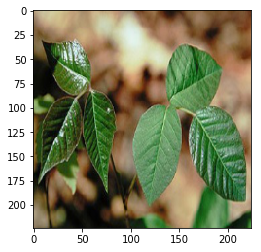

In [45]:
img = skimage.transform.resize(img, (224,224))
plt.imshow(img)
plt.show()

In [34]:
shorter_edge = min(img.shape[:2])
crop_height = (img.shape[0] - shorter_edge) / 2
crop_width = (img.shape[1] - shorter_edge) / 2
cropped_img = img[int(crop_height):int(crop_height + shorter_edge), int(crop_width):int(crop_width + shorter_edge)]
img = skimage.transform.resize(cropped_img, (224,224))

In [29]:
crop_width

59.0

In [21]:
(img.shape[0] - shorter_edge) / 2

0.0

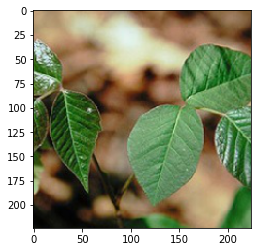

In [35]:
plt.imshow(img)
plt.show()

In [46]:
path_to_img = 'C:\\Users\\jltsa\\Desktop\\Project_2\\images'

In [68]:
data, labels = pre_process(227, 227, path_to_img)